# Analysis Notebook

#### Imports and settings

In [1]:
%matplotlib inline

In [58]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pandas as pd
import numpy as np

import requests
from pandas.io.json import json_normalize

import seaborn as sns
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import push_notebook, output_file, output_notebook, show
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.palettes import Plasma256, linear_palette

from sklearn.cross_validation import train_test_split

#MaxAbsScaler for Sparse, StandardScaler otherwise
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score


In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 160

plt.style.use('ggplot')

#sns.set_palette('husl', n_colors=20)

### Functions for querying and capturing data

In [ ]:
def yummly_search(query, page=1, n=400, start=0):

    """ Search yummly for ingredient or recipe name."""

    url = ('http://api.yummly.com/v1/api/recipes?_app_id=' + yummly_api + 
           '&_app_key=' + yummly_key + '&q=' + query + '&maxResult=' + str(n) + 
           '&start=' + str(start))

    return requests.get(url).json()

In [ ]:
def get_yummly_recipe(id):

    """ Request full recipe data for individual recipe """
    
    url = ('http://api.yummly.com/v1/api/recipe/' + id + '?_app_id=' +
           yummly_api + '&_app_key=' + yummly_key)
    
    return requests.get(url).json()

In [ ]:
# List of query terms to use in yummly_search()
yummly_list = ['beef', 'chicken', 'oats', 'corn', 'pasta', 'rice',
               'flour', 'potatoes', 'tomatoes', 'beans', 'apples',
               'milk', 'pork', 'fish', 'eggs', 'broccoli',
               'carrots', 'fruit', 'cheese', 'shrimp', 'butter', 'oil']

In [ ]:
def end_capture(query, n=400):

    """ Jump to end of query list to balance recipe ratings """
    
    head = yummly_search(query)
    end = head['totalMatchCount'] - (2 * n)

    return json_normalize(yummly_search(query, n=n, start=end), 'matches')

In [ ]:
def yummly_multi_recipe(n=10):

    """ Scripted multiple calls to get_yummly_recipe() to download full dataset """
    
    recipes = pd.read_pickle(path + '/yum_recipes3')
    start = recipes.index.max()
    try:
        while (recipes.index.max() < (start+n)):
            recipes = recipes.append(json_normalize(get_yummly_recipe(
                    remaining.iloc[len(recipes)])), ignore_index=True)
        recipes.to_pickle(path + '/yum_recipes3')
    except:
        recipes.to_pickle(path + '/yum_recipes3')
        print('**Error at %i **' % recipes.index.max())
        
    return recipes.index.max()

In [ ]:
def yummly_skip_recipe(n=1):

    """ Function to skip problematic recipe result after exception from yummly_multi_recipe()"""
    
    recipes = pd.read_pickle(path + '/yum_recipes3')
    start = recipes.index.max()
    while (recipes.index.max() < (start+n)):
        recipes = recipes.append(json_normalize(get_yummly_recipe(
                remaining.iloc[len(recipes)]+1)), ignore_index=True)
    
    recipes.to_pickle(path + '/yum_recipes3')
    
    return recipes.index.max()

### Nutrient list

In [4]:
nutrient_header = ['Nutr_No', 'Units', 'Tagname', 'NutrDesc', 'Num_Dec', 'SR_Order']
nutrients = pd.read_table('/data/sr28asc/NUTR_DEF.txt', sep='^', names=nutrient_header,
                         quotechar='~', index_col='Tagname', low_memory=False,
                          encoding='latin_1', usecols=['Tagname', 'NutrDesc', 'Units'])

In [38]:
print(nutrients)

                                   Units     Tagname
Tagname                                             
Protein                                g      PROCNT
Total lipid (fat)                      g         FAT
Carbohydrate, by difference            g      CHOCDF
Ash                                    g         ASH
Energy                              kcal  ENERC_KCAL
Starch                                 g      STARCH
Sucrose                                g        SUCS
Glucose (dextrose)                     g        GLUS
Fructose                               g        FRUS
Lactose                                g        LACS
Maltose                                g        MALS
Alcohol, ethyl                         g         ALC
Water                                  g       WATER
Adjusted Protein                       g         NaN
Caffeine                              mg       CAFFN
Theobromine                           mg      THEBRN
Energy                                kJ    EN

### Recipes were collected using above functions and a subset is shown below for illustration

In [6]:
recipes = pd.read_pickle('/home/mike/Documents/springboard/capstone_data/scraper/yum_recipes')

In [7]:
rc = recipes.rating.groupby(recipes.rating).count()
rc

rating
0       6
2       2
3     841
4    3031
5     325
dtype: int64

In [8]:
rc = rc.append(pd.Series([0], index=[1])).sort_index()

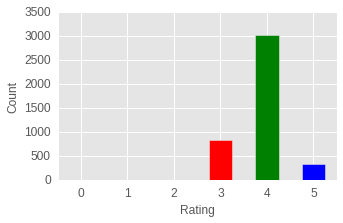

In [9]:
#ax = recipes['rating'].groupby(recipes.rating).count().plot(kind='bar', color=list('rgb'),
ax = rc.plot(kind='bar', color=list('rgb'),
                         figsize=(5,3), legend=False, fontsize=12, rot=0)
ax.set_xlabel("Rating", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()


### Nutrition information is primarily contained in the 'nutritionEstimates' column.  The structure is shown below.  This field was then parsed into individual columns and appended to the 'id'.  

### Rating information was remapped to '0' (low ratings of 0-3) or '1' (high ratings of 4-5) and stored as 'class_label'.

In [10]:
#nutrients = [record['attribute'] for record in recipes.nutritionEstimates[3633]]

#q = pd.DataFrame(columns=nutrients)

#for row in recipes.nutritionEstimates:
#    t = pd.Series({attribute['attribute']: attribute['value'] for attribute in row})
#    q = q.append(t, ignore_index=True)

# Recipe rating information contained in recipe list '/yum_recipes3'.
#recipes = recipes.append(pd.read_pickle(path + '/yum_recipes3'), ignore_index=True) 

#data = pd.read_csv(path + '/FinalYumData.csv')
#data = data.drop('Unnamed: 0', axis='columns')
#data['class_label'] = data.rating.map(lambda x: 1 if x>3 else 0)
#data.drop('rating', axis=1, inplace=True)

In [12]:
# Example record json response
recipes.iloc[0]['nutritionEstimates']

[{'attribute': 'K',
  'description': 'Potassium, K',
  'unit': {'abbreviation': 'g',
   'decimal': True,
   'id': '12485d26-6e69-102c-9a8a-0030485841f8',
   'name': 'gram',
   'plural': 'grams',
   'pluralAbbreviation': 'grams'},
  'value': 0.04},
 {'attribute': 'FLD',
  'description': 'Fluoride, F',
  'unit': {'abbreviation': 'g',
   'decimal': True,
   'id': '12485d26-6e69-102c-9a8a-0030485841f8',
   'name': 'gram',
   'plural': 'grams',
   'pluralAbbreviation': 'grams'},
  'value': 0.0},
 {'attribute': 'PHYSTR',
  'description': 'Phytosterols',
  'unit': {'abbreviation': 'g',
   'decimal': True,
   'id': '12485d26-6e69-102c-9a8a-0030485841f8',
   'name': 'gram',
   'plural': 'grams',
   'pluralAbbreviation': 'grams'},
  'value': 0.0},
 {'attribute': 'FASAT',
  'description': 'Fatty acids, total saturated',
  'unit': {'abbreviation': 'g',
   'decimal': True,
   'id': '12485d26-6e69-102c-9a8a-0030485841f8',
   'name': 'gram',
   'plural': 'grams',
   'pluralAbbreviation': 'grams'},
  

### Finally, the DataFrame was saved as a csv for future use.  Note that NaNs in each recipe's nutrient values were filled with '0'.

In [13]:
data = pd.read_csv('/home/mike/Documents/springboard/capstone_data/scraper/yum_data.csv', low_memory=False)

# Data Exploration

In [14]:
data.shape

(21143, 126)

In [15]:
data.dropna().shape

(20936, 126)

In [16]:
pd.Series(data.columns)

0                      Unnamed: 0
1                     class_label
2                numberOfServings
3              totalTimeInSeconds
4                        FAT_KCAL
5                               K
6                             FLD
7                          PHYSTR
8                           VAL_G
9                          SITSTR
10                         F18D1C
11                       F18D2CN6
12                          FASAT
13                         STARCH
14                         FOLDFE
15                           THIA
16                             MN
17                           GLUS
18                          ARG_G
19                          F16D1
20                          ALA_G
21                          FOLFD
22                             FE
23                       ENERC_KJ
24                         VITB6A
25                          ASP_G
26                       F18D3CN3
27                           FRUS
28                         TOCPHA
29            

### Drop non-nutritional / redundant features

In [17]:
data.drop(['Unnamed: 0', 'totalTimeInSeconds'], axis=1, inplace=True)

In [18]:
#drop any rows with all zeros
data = data.dropna()

In [19]:
data.head(2)

,class_label,numberOfServings,FAT_KCAL,K,FLD,PHYSTR,VAL_G,SITSTR,F18D1C,F18D2CN6,FASAT,STARCH,FOLDFE,THIA,MN,GLUS,ARG_G,F16D1,ALA_G,FOLFD,FE,ENERC_KJ,VITB6A,ASP_G,F18D3CN3,FRUS,TOCPHA,WATER,SUGAR,FAMS,GLY_G,ASH,SE,FIBTG,PROCNT,PHE_G,CHOCDF,FOL,VITK,F18D0,LEU_G,LYCPN,LUT+ZEA,CARTA,F20D0,CHOLE,STID7,CU,TOCPHG,P,PANTAC,CHOLN,CA,MG,CAMD5,FAPU,F14D0,VITA_RAE,NIA,CRYPX,GLU_G,F16D0,F18D1,F18D2,BETN,FOLAC,SUCS,CARTB,LYS_G,F18D3,SER_G,TOCPHD,VITA_IU,F20D1,ENERC_KCAL,VITC,RIBF,FAT,PRO_G,ZN,NA,FATRN,HISTN_G,ILE_G,MALS,RETOL,THR_G,TYR_G,VITB12,VITD-,GALS,F10D0,F12D0,F16D1C,F17D0,F18D1T,F4D0,F6D0,F8D0,MET_G,ALC,18:2 i,18:3i,FATRNP,F22D0,F24D0,Adjusted Protein,LACS,TOCPHB,FATRNM,TRP_G,CYS_G,F22D1,F24D1C,22:1 c,F22D6,CAFFN,F20D5,18:2 t not further defined,HYP,F20D4,THEBRN,"Vitamin B-12, added","Vitamin E, added"
0,1,4.0,0.0,0.04,0.0,0.00,0.0,0.0,0.0,0.0,0.03,0.03,0.30,0.0,0.0,0.08,0.00,0.00,0.00,0.0,0.00,106.18,0.0,0.00,0.0,0.08,0.0,0.33,4.88,0.03,0.00,0.60,0.0,0.68,0.28,0.0,6.53,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.02,0.01,0.0,0.03,0.0,0.38,0.00,0.0,0.00,0.03,0.03,0.03,0.00,0.0,4.75,0.0,0.00,0.0,0.0,0.0,7.48,0.0,25.38,0.0,0.0,0.08,0.00,0.00,0.20,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,4.0,210.0,0.63,0.0,0.01,1.7,0.0,0.0,0.0,8.33,35.15,237.09,0.0,0.0,2.35,1.13,1.13,1.13,0.0,0.01,2306.57,0.0,2.83,0.0,1.63,0.0,182.02,7.44,9.46,1.13,3.91,0.0,2.25,31.02,1.7,54.90,0.0,0.0,2.27,1.7,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.34,0.0,0.09,0.05,0.06,0.0,1.33,0.0,40.05,0.01,0.0,7.15,4.16,8.33,1.33,0.09,0.0,0.28,0.0,2.27,0.0,1.7,0.0,282.67,0.0,551.69,0.0,0.0,22.72,2.27,0.01,0.79,1.13,1.13,1.7,1.43,0.0,1.13,1.13,0.0,4.54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Collect nutrients only and scale to single serving

In [20]:
data = data.loc[:, (data != 0).any(axis=0)]

In [21]:
data.shape

(21140, 115)

In [22]:
#collect just nutrients as variable 'features' and scale to single serving
features = data.iloc[:,2:].divide(data.numberOfServings, axis=0)

In [23]:
#example record
features.iloc[3145]

FAT_KCAL                       165.000
K                                0.430
FLD                              0.000
PHYSTR                           0.000
VAL_G                            1.155
SITSTR                           0.000
F18D1C                           0.590
F18D2CN6                         1.120
FASAT                            7.485
STARCH                           0.000
FOLDFE                          14.610
THIA                             0.000
MN                               0.000
GLUS                             0.310
ARG_G                            1.010
F16D1                            0.420
ALA_G                            1.010
FE                               0.000
ENERC_KJ                      1222.585
VITB6A                           0.000
ASP_G                            1.745
F18D3CN3                         0.000
FRUS                             0.310
TOCPHA                           0.000
WATER                          112.060
SUGAR                    

In [25]:
split = data.class_label.map(lambda x: 'Favorable' if x==1 else 'Unfavorable')
#data['class_label'] = data.rating.map(lambda x: 1 if x>3 else 0)

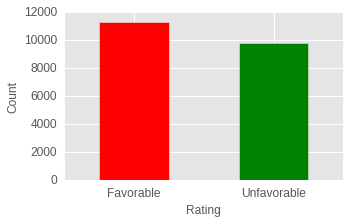

In [27]:
ax = split.groupby(split).count().plot(kind='bar', color=list('rgb'),
                         figsize=(5,3), fontsize=12, rot=0)
ax.set_xlabel("Rating", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

### Check for feature correlation with recipe rating (class_label)
While no strong correlations exist, a number of features are negatively correlated with ratings (coefficient ~ -0.1).  

In [39]:
clab = features.corrwith(data.class_label).sort_values(ascending=False)
print(pd.DataFrame(clab.iloc[:10]).round(3))

                      0
THEBRN            0.040
CAFFN             0.019
Vitamin E, added  0.016
HYP               0.013
GALS              0.013
CARTA             0.012
18:2 i            0.012
F22D0             0.011
18:3i             0.007
FLD               0.006


In [30]:
pd.Series(clab).sort_values(ascending=True)

K                            -0.178825
VITC                         -0.168881
WATER                        -0.168708
NIA                          -0.167963
FE                           -0.154841
ASH                          -0.152514
PROCNT                       -0.152284
ALA_G                        -0.145188
SER_G                        -0.141339
HISTN_G                      -0.139663
ILE_G                        -0.138189
PRO_G                        -0.137830
GLU_G                        -0.137721
VAL_G                        -0.136915
P                            -0.135274
PHE_G                        -0.134889
VITA_IU                      -0.132999
THR_G                        -0.129195
CHOLN                        -0.127898
GLY_G                        -0.123527
ENERC_KJ                     -0.122173
ENERC_KCAL                   -0.121485
ASP_G                        -0.120248
LEU_G                        -0.119551
F16D1                        -0.119092
FIBTG                    

#### Note correlation coefficients are primarily negative, but absolute values of coefficients are all < 0.18

[]

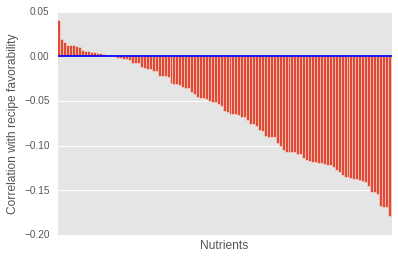

In [32]:
corrplot = clab.plot(kind='bar', figsize=(6,4), fontsize=10, width=1)
corrplot.axhline(0)
corrplot.set_ylabel('Correlation with recipe favorability')
corrplot.set_xlabel('Nutrients')
corrplot.xaxis.grid(False)
corrplot.axes.get_xaxis().set_ticks([])
#corrplot.axis('tight')
#corrplot.fill_between(cl.index, 0, cl)

In [40]:
print(pd.DataFrame(clab.iloc[-10:]).round(3))

             0
HISTN_G -0.140
SER_G   -0.141
ALA_G   -0.145
PROCNT  -0.152
ASH     -0.153
FE      -0.155
NIA     -0.168
WATER   -0.169
VITC    -0.169
K       -0.179


In [57]:
corrmat = features.corr()
corrmat

,FAT_KCAL,K,FLD,PHYSTR,VAL_G,SITSTR,F18D1C,F18D2CN6,FASAT,STARCH,FOLDFE,THIA,MN,GLUS,ARG_G,F16D1,ALA_G,FE,ENERC_KJ,VITB6A,ASP_G,F18D3CN3,FRUS,TOCPHA,WATER,SUGAR,FAMS,GLY_G,ASH,FIBTG,PROCNT,PHE_G,CHOCDF,F18D0,LEU_G,LYCPN,LUT+ZEA,CARTA,F20D0,CHOLE,STID7,CU,TOCPHG,P,PANTAC,CHOLN,CA,MG,CAMD5,FAPU,F14D0,VITA_RAE,NIA,CRYPX,GLU_G,F16D0,F18D1,F18D2,BETN,SUCS,CARTB,LYS_G,F18D3,SER_G,TOCPHD,VITA_IU,F20D1,ENERC_KCAL,VITC,FAT,PRO_G,ZN,NA,FATRN,HISTN_G,ILE_G,MALS,RETOL,THR_G,TYR_G,VITD-,GALS,F10D0,F12D0,F16D1C,F17D0,F18D1T,F4D0,F6D0,F8D0,MET_G,ALC,18:2 i,18:3i,FATRNP,F22D0,F24D0,Adjusted Protein,LACS,FATRNM,TRP_G,CYS_G,F22D1,F24D1C,22:1 c,F22D6,CAFFN,F20D5,18:2 t not further defined,HYP,F20D4,THEBRN,"Vitamin E, added"
FAT_KCAL,1.000000,0.607310,-0.003381,0.568255,0.585800,0.457062,0.612956,0.454364,0.859794,0.181597,0.440735,0.000603,0.145655,0.261674,0.561457,0.615966,0.559006,0.497726,0.890646,0.048531,0.542439,0.433952,0.192459,0.542385,0.495070,0.423798,0.926304,0.487645,0.701153,0.527127,0.637901,0.579869,0.541492,0.859728,0.546726,0.148122,0.044850,-0.004686,0.376069,0.591089,0.238090,0.082842,0.436769,0.674682,0.121060,0.565477,0.572888,0.603747,0.399655,0.735089,0.665219,0.520525,0.480917,0.003798,0.636297,0.899495,0.919286,0.722729,0.273738,0.293319,0.068111,0.484430,0.501793,0.591573,0.046555,0.302255,0.413104,0.895121,0.338560,0.999931,0.598272,0.426542,0.637187,0.205304,0.438936,0.580146,0.174450,0.009982,0.530696,0.386638,0.283270,0.091504,0.615354,0.343826,0.467427,0.467427,0.451269,0.610619,0.539905,0.351172,0.253108,0.033737,0.199614,0.200629,0.208193,0.105430,0.061111,0.105990,0.156034,0.087417,0.111451,0.104403,0.122972,0.075618,0.154315,0.118042,0.050686,0.108827,0.080817,0.017420,0.068056,0.109734,0.028681
K,0.607310,1.000000,-0.003080,0.475437,0.671320,0.273040,0.281776,0.182523,0.491511,0.363098,0.552556,0.025441,0.181283,0.452806,0.653837,0.454814,0.672554,0.638132,0.741558,0.036152,0.684000,0.179264,0.339319,0.390694,0.836101,0.404890,0.575466,0.636202,0.884949,0.813137,0.796526,0.661756,0.639080,0.482453,0.660213,0.327784,0.161281,0.010803,0.206220,0.462298,0.111640,0.054529,0.239057,0.848103,0.191902,0.640100,0.654761,0.821176,0.206730,0.452456,0.326527,0.489281,0.687062,0.025230,0.728693,0.539009,0.558547,0.426349,0.297583,0.159366,0.210489,0.621589,0.241590,0.668394,0.006501,0.471530,0.239791,0.748009,0.683192,0.607366,0.620101,0.473674,0.627574,0.149938,0.552984,0.659897,0.213903,0.034649,0.627205,0.543466,0.343454,0.085515,0.247918,0.195601,0.125562,0.125562,0.134469,0.256906,0.179478,0.177009,0.426997,0.059180,0.030879,0.034585,0.038150,0.075403,0.034696,0.220513,0.108292,0.050794,0.101217,0.122754,0.103768,0.074331,0.081234,0.170454,0.046328,0.117097,0.052685,0.000598,0.032616,0.084837,0.078995
FLD,-0.003381,-0.003080,1.000000,-0.002338,-0.002357,-0.001168,-0.001652,-0.001143,-0.003230,-0.002086,-0.002630,-0.000085,-0.000424,-0.001241,-0.002218,-0.000400,-0.002064,-0.002341,-0.003330,-0.000110,-0.002117,-0.001047,-0.000537,-0.001205,0.180629,-0.000649,-0.003082,-0.001510,-0.003561,-0.002826,-0.002885,-0.002233,-0.002314,-0.003260,-0.001917,-0.001162,-0.000649,-0.000092,-0.001034,-0.002468,-0.000494,-0.000111,-0.000958,-0.002932,-0.000446,-0.002630,0.002865,0.002587,-0.001010,-0.001928,-0.002552,-0.002577,-0.003309,-0.000113,-0.002943,-0.003186,-0.003090,-0.002239,-0.001848,0.000751,-0.001299,-0.001550,-0.001403,-0.002277,-0.000150,-0.002119,-0.001178,-0.003375,-0.000888,-0.003412,-0.002619,-0.001738,-0.000863,-0.000986,-0.000958,-0.002273,-0.001489,-0.000070,-0.001767,-0.001183,0.006041,-0.000781,-0.002226,-0.001400,-0.001368,-0.001368,-0.001398,-0.002153,-0.001897,-0.001349,-0.000139,-0.000410,-0.000459,-0.000414,-0.000462,-0.000347,-0.000157,-0.000832,-0.000820,-0.000426,-0.000783,-0.000403,-0.000448,-0.000285,-0.000432,0.005657,-0.000316,-0.000339,-0.000350,-0.000119,-0.000117,-0.000626,-0.000128
PHYSTR,0.568255,0.475437,-0.002338,1.000000,0.304706,0.142402,0.200670,0.368244,0.287893,0.142743,0.297375,0.0

### Examine statistics for each feature.  
Note that many contain zeros through 50th or even 75th percentile.

In [41]:
print(features.iloc[:,:5].describe().round({'FAT_KCAL':1, 
                                            'K':2, 
                                            'FLD':4, 
                                            'PHYSTR':3, 
                                            'VAL_G':2}))

       FAT_KCAL         K         FLD     PHYSTR     VAL_G
count   21140.0  21140.00  21140.0000  21140.000  21140.00
mean       51.6      0.16      0.0000      0.005      0.19
std        94.8      0.23      0.0000      0.015      0.34
min         0.0      0.00      0.0000      0.000      0.00
25%         4.2      0.01      0.0000      0.000      0.00
50%        23.3      0.08      0.0000      0.001      0.04
75%        62.5      0.21      0.0000      0.005      0.28
max      1810.0      2.95      0.0025      0.630      5.54


In [42]:
features.shape

(21140, 113)

### Evaluate nutrients by quantile to identify potential classification features.

In [43]:
q = pd.DataFrame(columns=features.columns)

#### Calculate percentage of recipes with high ratings across deciles.
Fraction of positively ranked recipes in each bin is

$\frac{positive}{all} = \frac{(1\times n_{pos})+(0\times n_{neg})}{(n_{pos} + n_{neg})} = \frac{\Sigma \textit{ class_label}}{n_{tot}} = mean(\it{class\_label})$

Decile distribution is calculated (using $\textit{rank}$ method to avoid non-unique bin-edge exception, and mean(class_label) is calculated for each decile and nutrient using groupby:

In [44]:
for column in features.columns:
    sub = data[[column, 'class_label']]
    bins = pd.cut(sub[column].rank(method='first'), 10, labels=False)  #calculate decile bins for each column
    grouped = sub.groupby([bins])                                      #groupby bins
    q[column] = grouped.mean().class_label                             #calculate mean(class_label) for each decile

In [45]:
q.index.name = 'Decile'            #rename index for use in unstacking/melting dataframe

### Visualize subset of recipes with positive ratings across deciles (subset shown):
Note that each nutrient displays a subset of deciles where the portion of negative ratings sharply increases which can be used to pre-evaluate recipes, or adjust contents during recipe development.

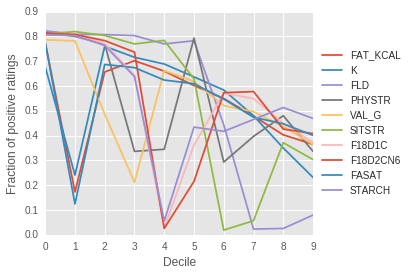

In [47]:
p = q.iloc[:,:10].plot(figsize=(6,4), legend=True)  #Evaluate 10 to start
p.set_ylabel("Fraction of positive ratings", fontsize=12)

box = p.get_position()
p.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
p.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [48]:
ns = np.sqrt(q.idxmin().value_counts(sort=False))
ns = ns.astype(float)

### Group nutrients by minimum decile

In [50]:
r = q.T
r['group'] = r.idxmin(axis=1)
r

Decile,0,1,2,3,4,5,6,7,8,9,group
FAT_KCAL,0.776254,0.172658,0.656575,0.701987,0.659886,0.601703,0.549669,0.478713,0.403027,0.364711,1
K,0.677862,0.240776,0.760170,0.715705,0.688742,0.636708,0.583728,0.480132,0.350047,0.231315,9
FLD,0.822138,0.808893,0.807474,0.803217,0.769631,0.782403,0.443236,0.023179,0.025544,0.079470,7
PHYSTR,0.815516,0.800378,0.768212,0.336329,0.344844,0.793283,0.293283,0.396878,0.480132,0.336329,6
VAL_G,0.786187,0.781930,0.486282,0.211921,0.662252,0.618259,0.520814,0.496689,0.436613,0.364238,3
SITSTR,0.809839,0.819300,0.803690,0.769631,0.783822,0.628666,0.018921,0.056764,0.371334,0.303217,6
F18D1C,0.806055,0.810785,0.771050,0.643803,0.028855,0.361873,0.571429,0.549196,0.449858,0.372280,4
F18D2CN6,0.812204,0.807947,0.782876,0.736518,0.025544,0.215232,0.572848,0.577578,0.426206,0.408231,4
FASAT,0.776727,0.124409,0.686850,0.674078,0.623936,0.609272,0.547304,0.473983,0.447493,0.401135,1
STARCH,0.806055,0.803217,0.763482,0.637654,0.055818,0.434248,0.417219,0.464995,0.513245,0.469253,4


In [52]:
counts = r.groupby(r.group).count()[0]
counts

group
1    23
2     4
3    12
4    10
5     9
6     9
7    40
8     1
9     5
Name: 0, dtype: int64

In [54]:
grouping = r.groupby(r.group).mean().T
grouping

group,1,2,3,4,5,6,7,8,9
Decile,,,,,,,,,
0,0.738555,0.793165,0.791548,0.807994,0.810522,0.813991,0.819891,0.795648,0.740019
1,0.192588,0.775307,0.785241,0.803075,0.808157,0.812783,0.808467,0.771050,0.443898
2,0.698861,0.166154,0.562638,0.774551,0.796436,0.801692,0.808775,0.381741,0.631883
3,0.696166,0.522588,0.167179,0.579470,0.774834,0.727268,0.795908,0.379849,0.621760
4,0.653099,0.656693,0.619836,0.065610,0.554084,0.731157,0.770293,0.696783,0.634248
5,0.595883,0.611045,0.595514,0.391438,0.035005,0.658520,0.796228,0.587985,0.625166
6,0.536156,0.532758,0.530590,0.554920,0.189635,0.051666,0.325745,0.517502,0.552602
7,0.470589,0.475993,0.475717,0.489593,0.478083,0.091611,0.024882,0.443709,0.464711
8,0.407223,0.440634,0.426167,0.457427,0.439031,0.333333,0.040622,0.362346,0.365847


### Plot nutrients grouped by minimum decile.  Line width represents number of nutrients in each group.

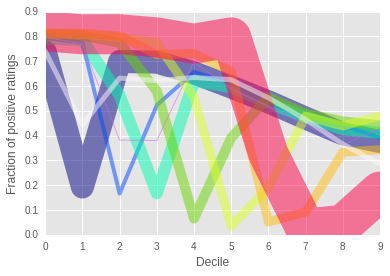

In [59]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

for decile in grouping:
    ax.plot(grouping[decile],
           lw=counts[decile],
           alpha=.5)
    
colormap = cm.gist_ncar
colors = [colormap(i) for i in np.linspace(0, 1, len(np.unique(r.group)))]

for i,j in enumerate(ax.lines):
    j.set_color(colors[i])

#ax.legend(bbox_to_anchor=(1.2, 1))

ax.set_ylabel('Fraction of positive ratings')
ax.set_xlabel('Decile')


### Full dataset with nutrients plotted individually.

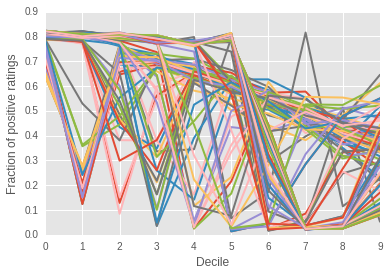

In [61]:
p = q.iloc[:,:-1].plot(figsize=(6,4), legend=False, lw=2)
p.set_ylabel("Fraction of positive ratings", fontsize=12)

#box = p.get_position()
#p.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#p.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Visualize full set of decile patterns

In [62]:
q['Decile'] = np.arange(1, 11, 1)

In [63]:
u = pd.melt(q, id_vars='Decile', var_name='nutrient')

In [64]:
u.columns

Index(['Decile', 'nutrient', 'value'], dtype='object')

### Redo visualization with Bokeh to allow drill-down into particular features

In [67]:
qb = q

In [68]:
qb = q.drop('Decile', axis=1)

In [69]:
output_notebook()
#output_file('lines.html')

TOOLS = 'pan,wheel_zoom,reset,tap,hover'
numlines = len(qb.columns)
mypalette=linear_palette(Plasma256, numlines)

z = figure(plot_width=500, plot_height=400, title=None, tools=TOOLS)

z.multi_line(xs=[qb.index.values]*numlines,
             ys=[qb[name].values for name in qb],
             line_color=mypalette,
             line_width=3,
             line_alpha=.5,
             )

Loading BokehJS ...

GlyphRenderer(id='be34aeb6-1de0-4b9b-ad8d-3abe2d35d3e5', ...)

In [70]:
show(z)

#### What is the outlier with peak at 7th decile?

In [71]:
q.columns[52]

'NIA'

In [72]:
data.NIA[data.NIA==0].count()

14594

Niacin is mostly zeros so unlikely a critical discriminant, but worth watching.

# Data preprocessing

### Split training and test data from dataset.  
X is the nutrient quantity for each recipe.  y is the class label for each recipe.


In [73]:
X = features
y = data.class_label

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=97)

### Data must be scaled for Logistic Regression. 
Scikit-learn's standard scaler applied to single-serving data:

In [77]:
scl = StandardScaler()  #or MAS

X_train_scl = scl.fit_transform(X_train)
X_test_scl = scl.transform(X_test)

## Logistic Regression

Initial classification with Logistic Regression was attempted with C=1 and L1 regularization (due to sparsity of many nutrients) with successful convergence and acceptable results.  Several other values of C were tested with little impact to accuracy and other metrics.  L2 regularization was also tested with little impact.  

In [78]:
cl = LogisticRegression(C=0.1, penalty='l1', n_jobs=-1)

In [79]:
cl.fit(X_train_scl, y_train)  #use scaled X values

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Logistic Regression weights were calculated and identified to provide insight to key nutrients

In [80]:
lr_weights = pd.Series(cl.coef_[0,:], index=features.columns)

In [81]:
lr_weights.sort_values(ascending=False)

LYS_G                         0.993781
TYR_G                         0.706234
F6D0                          0.552290
ASP_G                         0.540016
F18D3CN3                      0.464860
MG                            0.311487
F18D1T                        0.254354
VAL_G                         0.221757
LEU_G                         0.220983
F18D1                         0.215810
F14D0                         0.206635
CHOLN                         0.178608
SUGAR                         0.172270
LACS                          0.156187
F18D2                         0.154338
NA                            0.148162
FAT                           0.137591
CARTB                         0.132893
FATRNM                        0.129612
STARCH                        0.129287
F16D1C                        0.124560
FRUS                          0.094561
VITD-                         0.082899
CA                            0.081157
TRP_G                         0.075644
F8D0                     

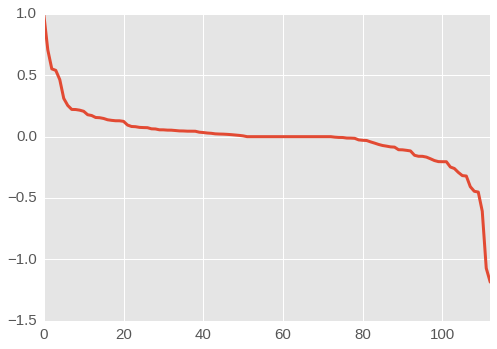

In [82]:
pd.DataFrame(cl.coef_).iloc[0,:].sort_values(ascending=False).plot(use_index=False, lw=3);

In [83]:
lr_weights.index[(lr_weights==0)].values

array(['FAT_KCAL', 'SITSTR', 'F18D2CN6', 'FASAT', 'F16D1', 'ENERC_KJ',
       'TOCPHA', 'FAMS', 'ASH', 'FIBTG', 'PHE_G', 'CHOLE', 'CU', 'FAPU',
       'VITA_RAE', 'F16D0', 'ENERC_KCAL', 'PRO_G', 'ILE_G', '18:2 i',
       'FATRNP', 'F22D0'], dtype=object)

In [84]:
newX = features.drop(lr_weights.index[(lr_weights==0)].values, axis=1)

In [85]:
newX_train, newX_test, newy_train, newy_test = train_test_split(
    newX, y, test_size=0.20, random_state=97)

scl2 = StandardScaler()  #or MAS

newX_train_scl = scl2.fit_transform(newX_train)
newX_test_scl = scl2.transform(newX_test)

In [86]:
cl2 = LogisticRegression(C=0.1, penalty='l1', n_jobs=-1)
cl2.fit(newX_train_scl, newy_train)  #use scaled X values

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Performance

Performance is first viewed as a confusion matrix to understand distribution of correct and incorrect classifications.

In [87]:
y_pred_lr = cl.predict(X_test_scl)  #use test set scaled using the same transform as the training set

In [88]:
confmat_lr = confusion_matrix(y_true=y_test, y_pred=y_pred_lr)
confmat_lr

array([[ 841, 1121],
       [ 302, 1964]])

Confusion matrix shows significant number of false positives (incorrectly classified as highly rated).

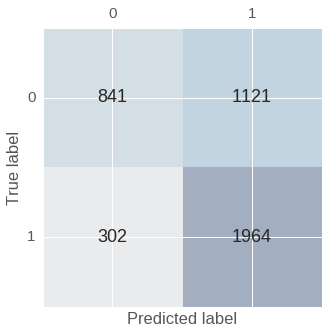

In [89]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat_lr, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_lr.shape[0]):
    for j in range(confmat_lr.shape[1]):
        ax.text(x=j, y=i, s=confmat_lr[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Other performance metrics:  Accuracy, Precision, Recall, F1, and Area Under ROC Curve

In [90]:
accuracy_score(y_true=y_test, y_pred=y_pred_lr)

0.66343424787133398

In [91]:
precision_score(y_true=y_test, y_pred=y_pred_lr)

0.63662884927066454

In [92]:
recall_score(y_true=y_test, y_pred=y_pred_lr)

0.86672550750220656

In [93]:
f1_score(y_true=y_test, y_pred=y_pred_lr)

0.7340683984302

In [94]:
y_score_lr = cl.predict_proba(X_test_scl)

In [95]:
roc_auc_score(y_test, y_score_lr[:,1])

0.69713108190662298

### Visualization using ROC curve

In [96]:
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_score_lr[:,1], pos_label=1)

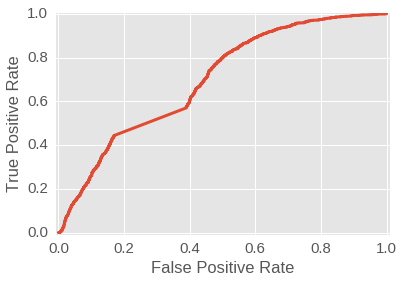

In [99]:
plt.figure(figsize=(6,4))
plt.xlabel('False Positive Rate')
plt.xlim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3)

### Repeat with dropped features:

In [100]:
newy_pred_lr = cl2.predict(newX_test_scl)  #use test set scaled using the same transform as the training set

In [101]:
confmat_lr2 = confusion_matrix(y_true=newy_test, y_pred=newy_pred_lr)
confmat_lr2

array([[ 841, 1121],
       [ 302, 1964]])

Confusion matrix shows significant number of false positives (incorrectly classified as highly rated).

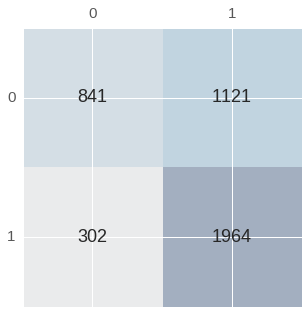

In [102]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat_lr2, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_lr2.shape[0]):
    for j in range(confmat_lr2.shape[1]):
        ax.text(x=j, y=i, s=confmat_lr2[i, j], va='center', ha='center')

### Other performance metrics:  Accuracy, Precision, Recall, F1, and Area Under ROC Curve

In [103]:
accuracy_score(y_true=newy_test, y_pred=newy_pred_lr)

0.66343424787133398

In [104]:
precision_score(y_true=newy_test, y_pred=newy_pred_lr)

0.63662884927066454

In [105]:
recall_score(y_true=newy_test, y_pred=newy_pred_lr)

0.86672550750220656

In [106]:
f1_score(y_true=newy_test, y_pred=newy_pred_lr)

0.7340683984302

In [107]:
newy_score_lr = cl2.predict_proba(newX_test_scl)

In [108]:
roc_auc_score(newy_test, newy_score_lr[:,1])

0.69714502736458739

### Minimal change between original and reduced-feature logistic regression

# Random Forest
The random forest uses the original training set (scaled only to per-serving quantities and no across-feature scaling).

In [109]:
rfc = RandomForestClassifier(n_estimators=10000, max_features='sqrt', random_state=1, n_jobs=-1)

In [110]:
%%time
rfc.fit(X_train, y_train)

CPU times: user 9min 13s, sys: 1.28 s, total: 9min 15s
Wall time: 2min 24s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

### Examine top features (most important) to understand how ratings are distributed

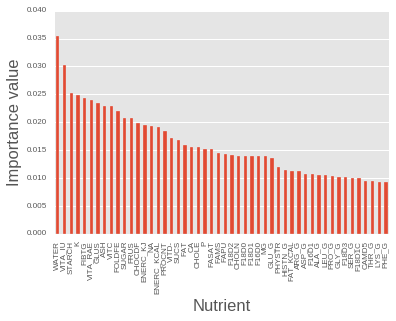

In [114]:
importances = pd.DataFrame({'Feature':data.columns[2:],
                            'Importance':rfc.feature_importances_}, index=data.columns[2:])
a = importances.sort_values(by='Importance', ascending=False)[:50].plot(kind='bar', figsize=(6,4),
                                                                  legend=False, fontsize=8)
a.set_xlabel('Nutrient')
a.set_ylabel('Importance value')
a.xaxis.grid(False)
#a.yaxis.grid(True, color='w')


plt.show()

In [115]:
importances.Importance.sort_values(ascending=False)

WATER                         0.035414
VITA_IU                       0.030281
STARCH                        0.025278
K                             0.024872
FIBTG                         0.024276
VITA_RAE                      0.023971
GLUS                          0.023429
ASH                           0.022971
VITC                          0.022834
FOLDFE                        0.021950
SUGAR                         0.020781
FRUS                          0.020780
CHOCDF                        0.019930
ENERC_KJ                      0.019486
NA                            0.019254
ENERC_KCAL                    0.019142
PROCNT                        0.018421
VITD-                         0.017126
SUCS                          0.016731
FAT                           0.015868
CA                            0.015589
CHOLE                         0.015503
P                             0.015151
FASAT                         0.015142
FAMS                          0.014436
FAPU                     

In [116]:
eda = pd.DataFrame(data, columns=importances.sort_values(by='Importance', ascending=False).Feature[:5])
eda['label'] = data.class_label

In [117]:
sns.set_palette('husl', n_colors=5)
sns.set(style='ticks', color_codes=True)

In [120]:
eda.head()

Feature,WATER,VITA_IU,STARCH,K,FIBTG,label
0,0.33,7.48,0.03,0.04,0.68,1
1,182.02,282.67,35.15,0.63,2.25,1
2,213.24,54.60,0.00,0.83,0.09,1
3,2.41,355.39,0.00,0.03,0.25,1
4,72.24,16.42,0.00,0.11,0.27,1


In [121]:
plt.style.use('fivethirtyeight')

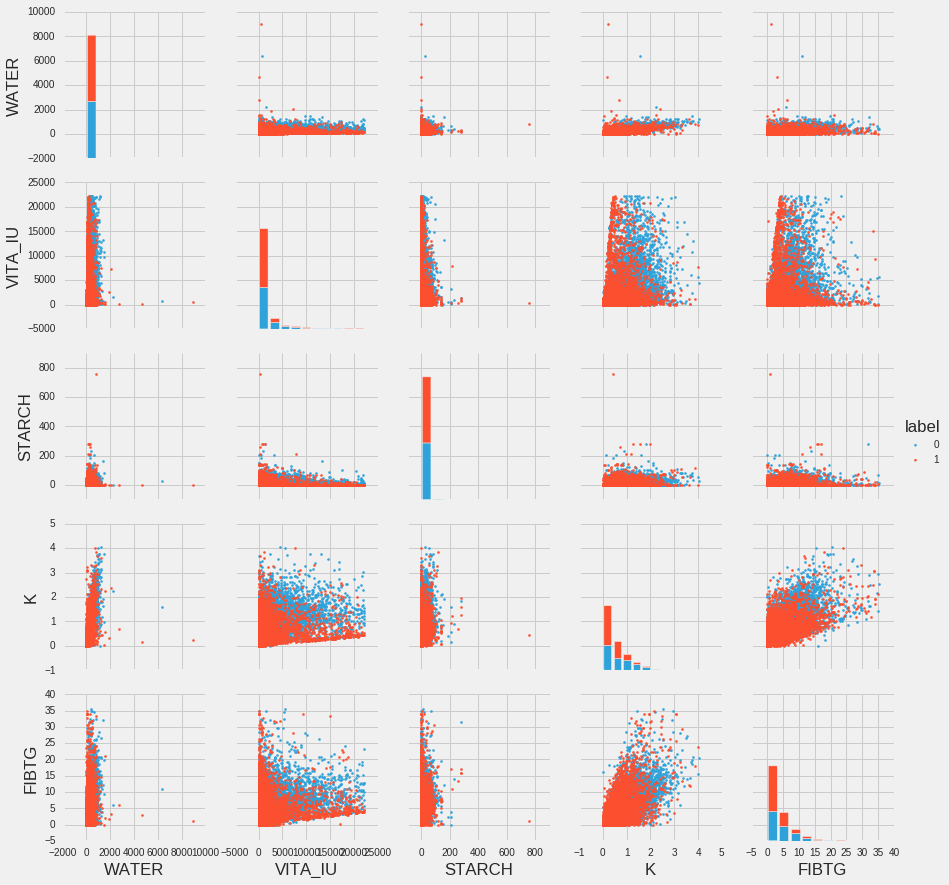

In [122]:
grid = sns.PairGrid(eda, hue='label', vars=eda.columns[:-1])
grid = grid.map_diag(plt.hist)
#grid = grid.map_lower(sns.kdeplot)
grid = grid.map_offdiag(plt.scatter, s=4)
grid = grid.add_legend()

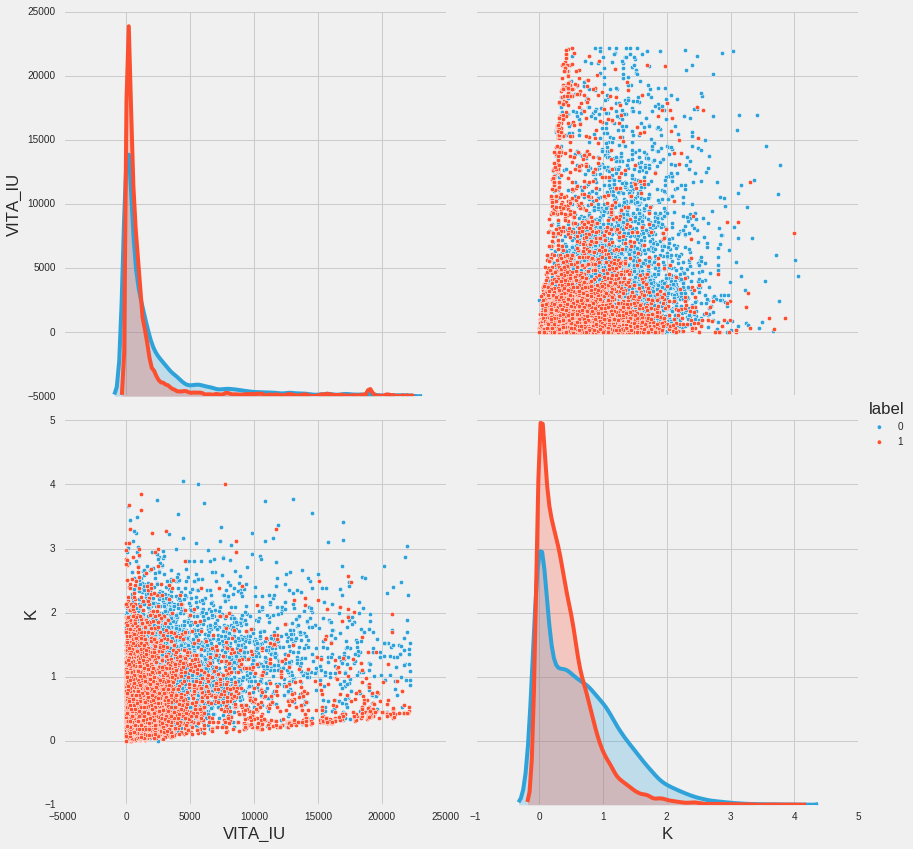

In [123]:
p = sns.pairplot(eda, vars=['VITA_IU', 'K'], hue='label', size=6, diag_kind='kde', diag_kws=dict(shade=True))

### RF Performance
Identical analysis as presented above.

In [124]:
y_pred = rfc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat

array([[1364,  598],
       [ 497, 1769]])

Confusion matrix demonstrates much better performance than Logistic Regression in terms of False Positives and True Negatives.

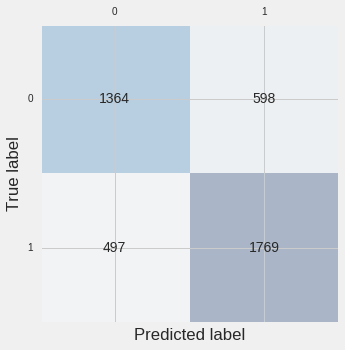

In [125]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [126]:
accuracy_score(y_true=y_test, y_pred=y_pred) # vs LR:.67

0.74101229895931886

In [127]:
precision_score(y_true=y_test, y_pred=y_pred) # vs LR:.64

0.74735952682720741

In [128]:
recall_score(y_true=y_test, y_pred=y_pred) # vs LR:.87

0.78067078552515445

In [129]:
f1_score(y_true=y_test, y_pred=y_pred) # vs LR:.74

0.76365206129937402

In [130]:
y_score = rfc.predict_proba(X_test)

In [131]:
roc_auc_score(y_test, y_score[:,1]) # vs LR:.70

0.8018086134346043

In [132]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1], pos_label=1)

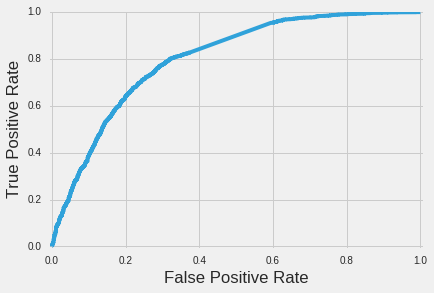

In [133]:
r = plt.figure(figsize=(6,4))
plt.xlabel('False Positive Rate')
plt.xlim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr)
plt.savefig('/home/mike/Dropbox/ROC.pdf')

### Identify trees for successful classifications
Using TreeInterpreter (pip installable)

In [134]:
rfc.estimators_[0]   #examine structure of information from individual trees

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1791095845, splitter='best')

Collect samples with highest probability to be positively rated using .predict_proba()

In [135]:
probs = pd.Series(rfc.predict_proba(X_test)[:,1])  

In [136]:
top = probs.sort_values(ascending=False).index[:10]

In [137]:
rfc.predict_proba(X_test)[:,1].argmax()

2596

In [138]:
# TreeInterpreter uses prediction probabilities and 
prediction, bias, contributions = ti.predict(rfc, X_test.iloc[top])

In [139]:
prediction

array([[ 0.0072    ,  0.9928    ],
       [ 0.0112    ,  0.9888    ],
       [ 0.01837667,  0.98162333],
       [ 0.0234    ,  0.9766    ],
       [ 0.0306    ,  0.9694    ],
       [ 0.0338    ,  0.9662    ],
       [ 0.0338    ,  0.9662    ],
       [ 0.0379    ,  0.9621    ],
       [ 0.0392    ,  0.9608    ],
       [ 0.0398    ,  0.9602    ]])

In [141]:
bias[0]

array([ 0.46331901,  0.53668099])

In [145]:
contributions[0]

array([[ -3.13363701e-03,   3.13363701e-03],
       [ -2.22247755e-02,   2.22247755e-02],
       [  0.00000000e+00,   0.00000000e+00],
       [ -1.01688514e-03,   1.01688514e-03],
       [ -2.36770392e-03,   2.36770392e-03],
       [ -6.61041112e-03,   6.61041112e-03],
       [ -4.65428796e-03,   4.65428796e-03],
       [ -6.76665316e-03,   6.76665316e-03],
       [ -7.69493911e-03,   7.69493911e-03],
       [ -1.61399589e-02,   1.61399589e-02],
       [ -7.01179612e-03,   7.01179612e-03],
       [ -6.57904862e-07,   6.57904862e-07],
       [ -2.95144142e-05,   2.95144142e-05],
       [ -5.51720816e-03,   5.51720816e-03],
       [ -4.63956589e-04,   4.63956589e-04],
       [ -1.92895093e-03,   1.92895093e-03],
       [ -4.35355469e-03,   4.35355469e-03],
       [ -4.23900057e-03,   4.23900057e-03],
       [ -1.04704244e-02,   1.04704244e-02],
       [  0.00000000e+00,   0.00000000e+00],
       [ -4.83604154e-04,   4.83604154e-04],
       [  4.12718526e-03,  -4.12718526e-03],
       [ -

In [146]:
contributions.shape

(10, 113, 2)

### Each instance below shows a tree that classified a test sample as highly rated with high probability, and the relative importances of its features.

In [147]:
# following TI documentation example:

for i in range(len(top)):
    print( "Instance", i)
    print("Bias (trainset mean)", bias[i])
    print( "Feature contributions:")
    for c, feature in sorted(zip(contributions[i,:,1], features.columns),
                            key=lambda x: -abs(x[0])):
        print(feature, c)
    print( "-"*20 )

Instance 0
Bias (trainset mean) [ 0.46331901  0.53668099]
Feature contributions:
WATER 0.0269549068446
VITC 0.0241563603413
K 0.0222247754736
ASH 0.0166130476925
STARCH 0.0161399588893
FIBTG 0.0147595372469
VITA_IU 0.0110160515964
ENERC_KCAL 0.0107574952763
PROCNT 0.0107545266314
ENERC_KJ 0.0104704243686
CA 0.0101761916221
P 0.00980384305983
FAMS 0.00912304088793
NA 0.00901037304084
F18D1 0.00828534617717
MG 0.0082741567907
CHOCDF 0.00811857538709
VITA_RAE 0.00777221249677
F18D2 0.00774498556785
FASAT 0.00769493911263
18:2 i 0.00717711320007
18:3i 0.00714327204941
FOLDFE 0.00701179611851
GLU_G 0.00700211983369
CAMD5 0.00680002726752
F16D0 0.00679282743942
F18D2CN6 0.0067666531586
SITSTR 0.00661041112298
FAPU 0.00651112020532
F18D3 0.0064116331941
FAT 0.006227731098
HISTN_G 0.00589516088404
CHOLN 0.00574170923149
GLUS 0.00551720816011
SER_G 0.00535546967175
GLY_G 0.00487392523425
F20D0 0.00471440505429
F18D1C 0.00465428795674
F20D1 0.0046098236285
ALA_G 0.00435355469112
FE 0.00423900056

### Select single top-confidence tree to show in relation to aggregate

In [149]:
feat = {feature : c for c, feature in sorted(zip(contributions[0,:,1], features.columns))}

In [150]:
feat

{'18:2 i': 0.0071771132000677329,
 '18:2 t not further defined': 0.00071081817113200678,
 '18:3i': 0.0071432720494103508,
 '22:1 c': 0.00067276679248375493,
 'ALA_G': 0.0043535546911154703,
 'ALC': 0.0017911227961723163,
 'ARG_G': 0.00046395658873789011,
 'ASH': 0.016613047692457639,
 'ASP_G': 0.00048360415398640371,
 'Adjusted Protein': 0.00067447862330362676,
 'BETN': -0.00070956125540498724,
 'CA': 0.01017619162211637,
 'CAFFN': 0.00042739840068173047,
 'CAMD5': 0.0068000272675232737,
 'CARTA': 0.0,
 'CARTB': 0.00010402590490815085,
 'CHOCDF': 0.0081185753870887892,
 'CHOLE': 0.0030591705928529412,
 'CHOLN': 0.0057417092314851429,
 'CRYPX': 0.0,
 'CU': 0.0,
 'CYS_G': 0.00033823501320761679,
 'ENERC_KCAL': 0.010757495276329859,
 'ENERC_KJ': 0.010470424368606511,
 'F10D0': 0.0014330029102101068,
 'F12D0': 0.0025609678255677968,
 'F14D0': 0.0034410518997992747,
 'F16D0': 0.0067928274394189045,
 'F16D1': 0.001928950926077394,
 'F16D1C': 0.00051385778750679463,
 'F17D0': 0.00049318116970

### Individual tree feature importances are aggregated up to present the overall feature importances from the ensemble

In [151]:
feature_list = pd.Series(X.columns)

In [152]:
impSer = pd.Series(rfc.feature_importances_, index=feature_list, )
impSer

FAT_KCAL                      0.011316
K                             0.024872
FLD                           0.000001
PHYSTR                        0.011935
VAL_G                         0.008571
SITSTR                        0.005953
F18D1C                        0.009936
F18D2CN6                      0.008067
FASAT                         0.015142
STARCH                        0.025278
FOLDFE                        0.021950
THIA                          0.000013
MN                            0.000159
GLUS                          0.023429
ARG_G                         0.011289
F16D1                         0.010734
ALA_G                         0.010574
FE                            0.007149
ENERC_KJ                      0.019486
VITB6A                        0.000007
ASP_G                         0.010784
F18D3CN3                      0.008891
FRUS                          0.020780
TOCPHA                        0.001155
WATER                         0.035414
SUGAR                    

In [154]:
feat = pd.Series(feat)

In [155]:
importances = pd.DataFrame({'Feature':data.columns[2:],
                            'Importance':rfc.feature_importances_}, index=data.columns[2:])

In [156]:
importances['toptree'] = feat

In [157]:
importances.head()

,Feature,Importance,toptree
FAT_KCAL,FAT_KCAL,0.011316,0.003134
K,K,0.024872,0.022225
FLD,FLD,0.000001,0.000000
PHYSTR,PHYSTR,0.011935,0.001017
VAL_G,VAL_G,0.008571,0.002368


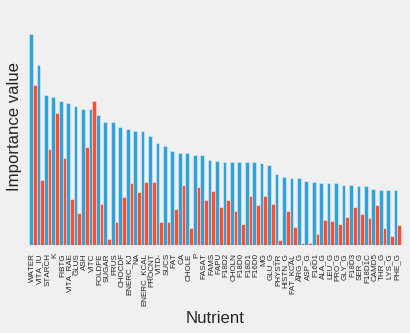

In [160]:
a = importances.sort_values(by='Importance', ascending=False)[:50].plot(kind='bar', figsize=(6,4),
                                                                  legend=False, fontsize=8,
                                                                       width=1)
a.set_xlabel('Nutrient')
a.set_ylabel('Importance value')
a.xaxis.grid(False)
a.axes.get_yaxis().set_ticks([])
#a.yaxis
#a.yaxis.grid(True, color='w')


plt.show()

### Note orange is individual (top) tree, and blue is aggregate (top 50 features).